In [1]:
# packages
import pandas as pd
import numpy as np
import pyarrow as pa
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('max_colwidth', None)
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn import linear_model
from sklearn.preprocessing import MinMaxScaler

In [2]:
#preparing dataframe
#Save the dataframes in the same directory as the notebook for the below reads to work. 
df2018 = pd.read_parquet('Combined_Flights_2018.parquet', engine='pyarrow')
df2019 = pd.read_parquet('Combined_Flights_2019.parquet', engine='pyarrow')
df2020 = pd.read_parquet('Combined_Flights_2020.parquet', engine='pyarrow')
df2021 = pd.read_parquet('Combined_Flights_2021.parquet', engine='pyarrow')
df2022 = pd.read_parquet('Combined_Flights_2022.parquet', engine='pyarrow')

#frames = [df2018, df2019,df2020,df2021,df2022]
#df=pd.concat(frames)

# I was struggling to get code to run with all data, dropped down to a single year here. BH
df = df2021

In [3]:
len(df.index)

6311871

In [4]:
df.dropna(inplace=True)

In [5]:
len(df.index)

6185869

In [6]:
df.head()

,FlightDate,Airline,Origin,Dest,Cancelled,Diverted,CRSDepTime,DepTime,DepDelayMinutes,DepDelay,...,WheelsOff,WheelsOn,TaxiIn,CRSArrTime,ArrDelay,ArrDel15,ArrivalDelayGroups,ArrTimeBlk,DistanceGroup,DivAirportLandings
0,2021-03-03,SkyWest Airlines Inc.,SGU,PHX,False,False,724,714.0,0.0,-10.0,...,724.0,813.0,5.0,843,-25.0,0.0,-2.0,0800-0859,2,0.0
1,2021-03-03,SkyWest Airlines Inc.,PHX,SGU,False,False,922,917.0,0.0,-5.0,...,940.0,1028.0,3.0,1040,-9.0,0.0,-1.0,1000-1059,2,0.0
2,2021-03-03,SkyWest Airlines Inc.,MHT,ORD,False,False,1330,1321.0,0.0,-9.0,...,1336.0,1445.0,16.0,1530,-29.0,0.0,-2.0,1500-1559,4,0.0
3,2021-03-03,SkyWest Airlines Inc.,DFW,TRI,False,False,1645,1636.0,0.0,-9.0,...,1703.0,1955.0,7.0,2010,-8.0,0.0,-1.0,2000-2059,4,0.0
4,2021-03-03,SkyWest Airlines Inc.,PHX,BFL,False,False,1844,1838.0,0.0,-6.0,...,1851.0,1900.0,3.0,1925,-22.0,0.0,-2.0,1900-1959,2,0.0


In [7]:
df.shape

(6185869, 61)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6185869 entries, 0 to 573778
Data columns (total 61 columns):
 #   Column                                   Dtype         
---  ------                                   -----         
 0   FlightDate                               datetime64[ns]
 1   Airline                                  object        
 2   Origin                                   object        
 3   Dest                                     object        
 4   Cancelled                                bool          
 5   Diverted                                 bool          
 6   CRSDepTime                               int64         
 7   DepTime                                  float64       
 8   DepDelayMinutes                          float64       
 9   DepDelay                                 float64       
 10  ArrTime                                  float64       
 11  ArrDelayMinutes                          float64       
 12  AirTime                           

In [9]:
# This allows all 61 features to start showing up in our describe()
pd.set_option('display.max_columns', None)
# include = 'all' gives us some extra stats
df.describe(include='all')

,FlightDate,Airline,Origin,Dest,Cancelled,Diverted,CRSDepTime,DepTime,DepDelayMinutes,DepDelay,ArrTime,ArrDelayMinutes,AirTime,CRSElapsedTime,ActualElapsedTime,Distance,Year,Quarter,Month,DayofMonth,DayOfWeek,Marketing_Airline_Network,Operated_or_Branded_Code_Share_Partners,DOT_ID_Marketing_Airline,IATA_Code_Marketing_Airline,Flight_Number_Marketing_Airline,Operating_Airline,DOT_ID_Operating_Airline,IATA_Code_Operating_Airline,Tail_Number,Flight_Number_Operating_Airline,OriginAirportID,OriginAirportSeqID,OriginCityMarketID,OriginCityName,OriginState,OriginStateFips,OriginStateName,OriginWac,DestAirportID,DestAirportSeqID,DestCityMarketID,DestCityName,DestState,DestStateFips,DestStateName,DestWac,DepDel15,DepartureDelayGroups,DepTimeBlk,TaxiOut,WheelsOff,WheelsOn,TaxiIn,CRSArrTime,ArrDelay,ArrDel15,ArrivalDelayGroups,ArrTimeBlk,DistanceGroup,DivAirportLandings
count,6185869,6185869,6185869,6185869,6185869,6185869,6.185869e+06,6.185869e+06,6.185869e+06,6.185869e+06,6.185869e+06,6.185869e+06,6.185869e+06,6.185869e+06,6.185869e+06,6.185869e+06,6185869.0,6.185869e+06,6.185869e+06,6.185869e+06,6.185869e+06,6185869,6185869,6.185869e+06,6185869,6.185869e+06,6185869,6.185869e+06,6185869,6185869,6.185869e+06,6.185869e+06,6.185869e+06,6.185869e+06,6185869,6185869,6.185869e+06,6185869,6.185869e+06,6.185869e+06,6.185869e+06,6.185869e+06,6185869,6185869,6.185869e+06,6185869,6.185869e+06,6.185869e+06,6.185869e+06,6185869,6.185869e+06,6.185869e+06,6.185869e+06,6.185869e+06,6.185869e+06,6.185869e+06,6.185869e+06,6.185869e+06,6185869,6.185869e+06,6185869.0
unique,NaN,22,380,380,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10,15,NaN,10,NaN,22,NaN,22,5758,NaN,NaN,NaN,NaN,374,53,NaN,53,NaN,NaN,NaN,NaN,374,53,NaN,53,NaN,NaN,NaN,19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19,NaN,NaN
top,NaN,Southwest Airlines Co.,ATL,ATL,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AA,WN,NaN,AA,NaN,WN,NaN,WN,N480HA,NaN,NaN,NaN,NaN,"Chicago, IL",TX,NaN,Texas,NaN,NaN,NaN,NaN,"Chicago, IL",TX,NaN,Texas,NaN,NaN,NaN,0800-0859,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1600-1659,NaN,NaN
freq,NaN,1038760,310617,310757,6185869,6185869,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1636403,1038760,NaN,1636403,NaN,1038760,NaN,1038760,2888,NaN,NaN,NaN,NaN,341709,678000,NaN,678000,NaN,NaN,NaN,NaN,341212,676778,NaN,676778,NaN,NaN,NaN,447460,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,413413,NaN,NaN
mean,2021-07-15 14:08:26.530609152,NaN,NaN,NaN,NaN,NaN,1.322929e+03,1.326691e+03,1.269843e+01,9.402450e+00,1.476631e+03,1.252927e+01,1.105702e+02,1.405494e+02,1.344372e+02,7.960703e+02,2021.0,2.650939e+00,6.971771e+00,1.578911e+01,4.014697e+00,NaN,NaN,1.983133e+04,NaN,2.794061e+03,NaN,2.001231e+04,NaN,NaN,2.794050e+03,1.265947e+04,1.265950e+06,3.174996e+04,NaN,NaN,2.739722e+01,NaN,5.502324e+01,1.266003e+04,1.266007e+06,3.175102e+04,NaN,NaN,2.739738e+01,NaN,5.501910e+01,1.726682e-01,-1.899652e-02,NaN,1.618915e+01,1.349695e+03,1.471336e+03,7.677849e+00,1.497352e+03,3.290242e+00,1.726609e-01,-3.158287e-01,NaN,3.655957e+00,0.0
min,2021-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,1.000000e+00,1.000000e+00,0.000000e+00,-1.050000e+02,1.000000e+00,0.000000e+00,8.000000e+00,-2.920000e+02,1.400000e+01,3.100000e+01,2021.0,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,NaN,NaN,1.939300e+04,NaN,1.000000e+00,NaN,1.939300e+04,NaN,NaN,1.000000e+00,1.013500e+04,1.013506e+06,3.007000e+04,NaN,NaN,1.000000e+00,NaN,1.000000e+00,1.013500e+04,1.013506e+06,3.007000e+04,NaN,NaN,1.000000e+00,NaN,1.000000e+00,0.000000e+00,-2.000000e+00,NaN,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,-1.070000e+02,0.000000e+00,-2.000000e+00,NaN,1.000000e+00,0.0
25%,2021-04-25 00:00:00,NaN,NaN,NaN,NaN,NaN,9.200000e+02,9.220000e+02,0.000000e+00,-6.000000e+00,1.105000e+03,0.000000e+00,6.000000e+01,9.000000e+01,8.300000e+01,3.700000e+02,2021.0,2.000000e+00,4.000000e+00,8.000000e+00,2.000000e+00,NaN,NaN,1.979000e+04,NaN,1.193000e+03,NaN,1.979000e+04,NaN,NaN,1.193000e+03,1.129200e+04,1.12920

<__array_function__ internals>:200: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:200: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


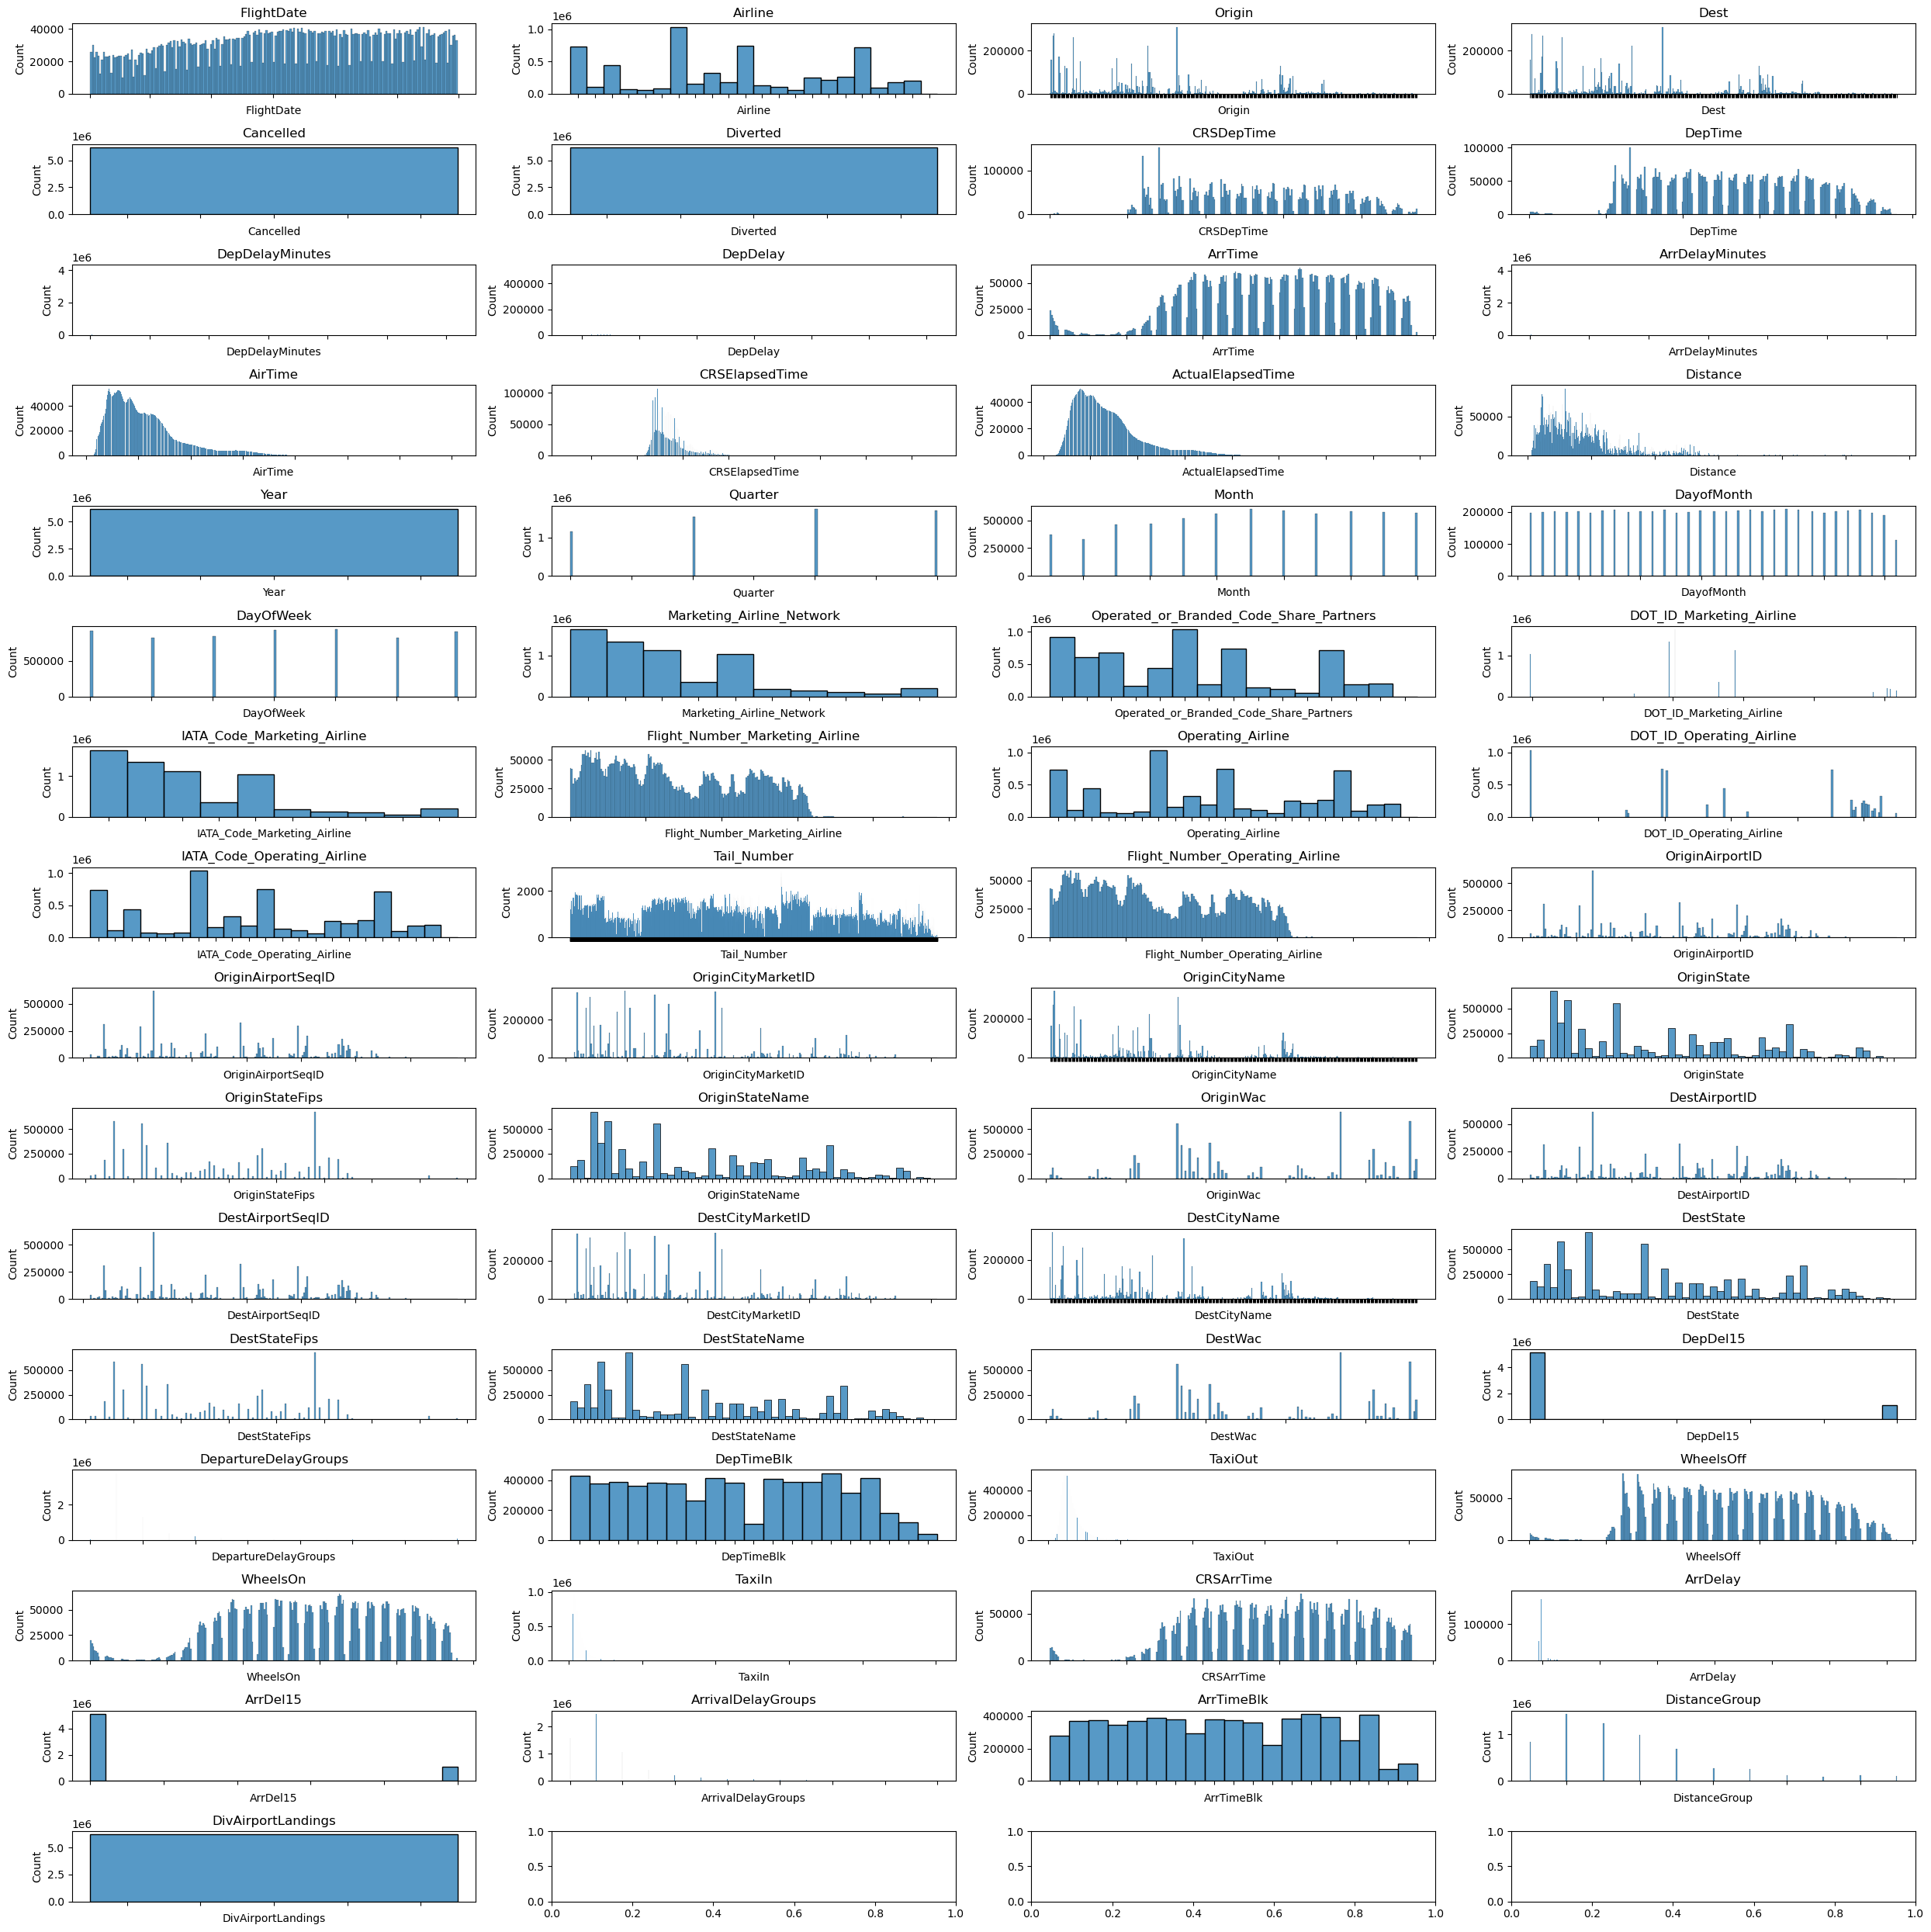

In [10]:
# Creating histograms for every feature. Blank histograms are due to NaN values for some reason. Still need to play with those features.
fig, axs = plt.subplots(16, 4, figsize=(25, 25))
fig.subplots_adjust(hspace=.2)

for i, feat in enumerate(df.columns):
    row = i // 4
    col = i % 4
    sns.histplot(data=df, x=feat, kde=False, ax=axs[row, col])
    axs[row, col].set_xticklabels([])
    axs[row, col].set_title(f'{feat}')

plt.tight_layout()
plt.show()

# Can safely ignore the following error... it will run eventually
# <__array_function__ internals>:200: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.

In [12]:
# Determining number of unique values for each feature.... nunique() ignores NaN
print("Unique values for each feature, excluding NaN")
print("-------")
for i, feat in enumerate(df.columns):
    print(f"Feature '{feat}' has {df[feat].nunique()} unique values.")

Unique values for each feature, excluding NaN
-------
Feature 'FlightDate' has 365 unique values.
Feature 'Airline' has 22 unique values.
Feature 'Origin' has 380 unique values.
Feature 'Dest' has 380 unique values.
Feature 'Cancelled' has 1 unique values.
Feature 'Diverted' has 1 unique values.
Feature 'CRSDepTime' has 1317 unique values.
Feature 'DepTime' has 1440 unique values.
Feature 'DepDelayMinutes' has 1605 unique values.
Feature 'DepDelay' has 1667 unique values.
Feature 'ArrTime' has 1440 unique values.
Feature 'ArrDelayMinutes' has 1601 unique values.
Feature 'AirTime' has 671 unique values.
Feature 'CRSElapsedTime' has 590 unique values.
Feature 'ActualElapsedTime' has 699 unique values.
Feature 'Distance' has 1607 unique values.
Feature 'Year' has 1 unique values.
Feature 'Quarter' has 4 unique values.
Feature 'Month' has 12 unique values.
Feature 'DayofMonth' has 31 unique values.
Feature 'DayOfWeek' has 7 unique values.
Feature 'Marketing_Airline_Network' has 10 unique v

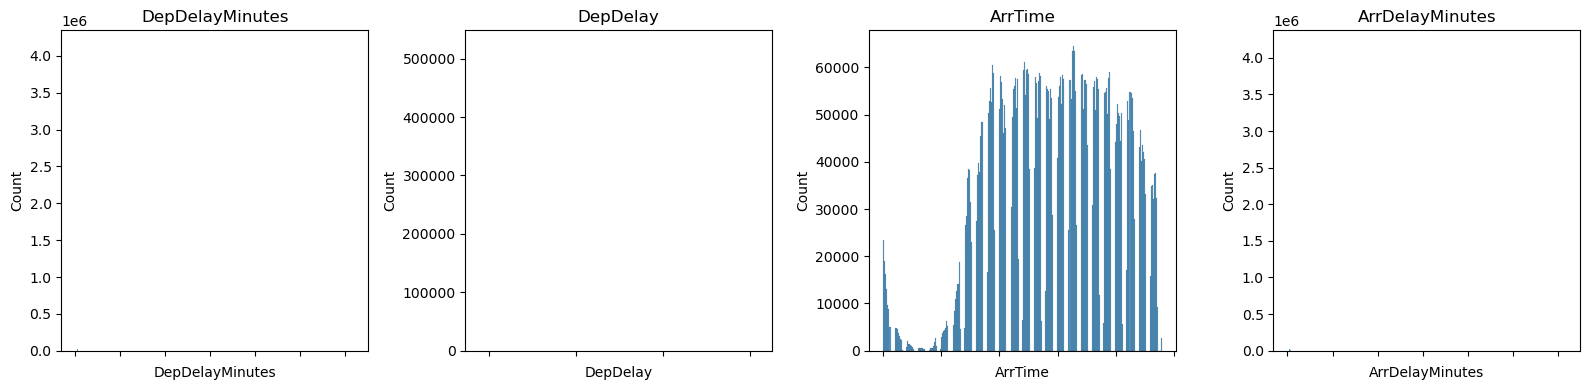

In [13]:
# Selecting 4 features for testing. These histograms are showing as blank due to NaN values breaking stuff...
test_df = df.columns[8:12]

fig, axs = plt.subplots(1, 4, figsize=(16, 4))
fig.subplots_adjust(hspace=.2)

for i, feat in enumerate(test_df):
    sns.histplot(data=df, x=feat, kde=False, ax=axs[i])
    axs[i].set_xticklabels([])
    axs[i].set_title(f'{feat}')

plt.tight_layout()
plt.show()

In [7]:
# Make correlation matrix df that only uses numerical values. 
corr_df = df.select_dtypes(include=['number'])
# bad features below that are technically numbers, but useless
corr_df = corr_df.drop('Year', axis=1)
corr_df = corr_df.drop('DivAirportLandings', axis=1)
# Actually makes the correlation matrix
corr_matrix = corr_df.corr()

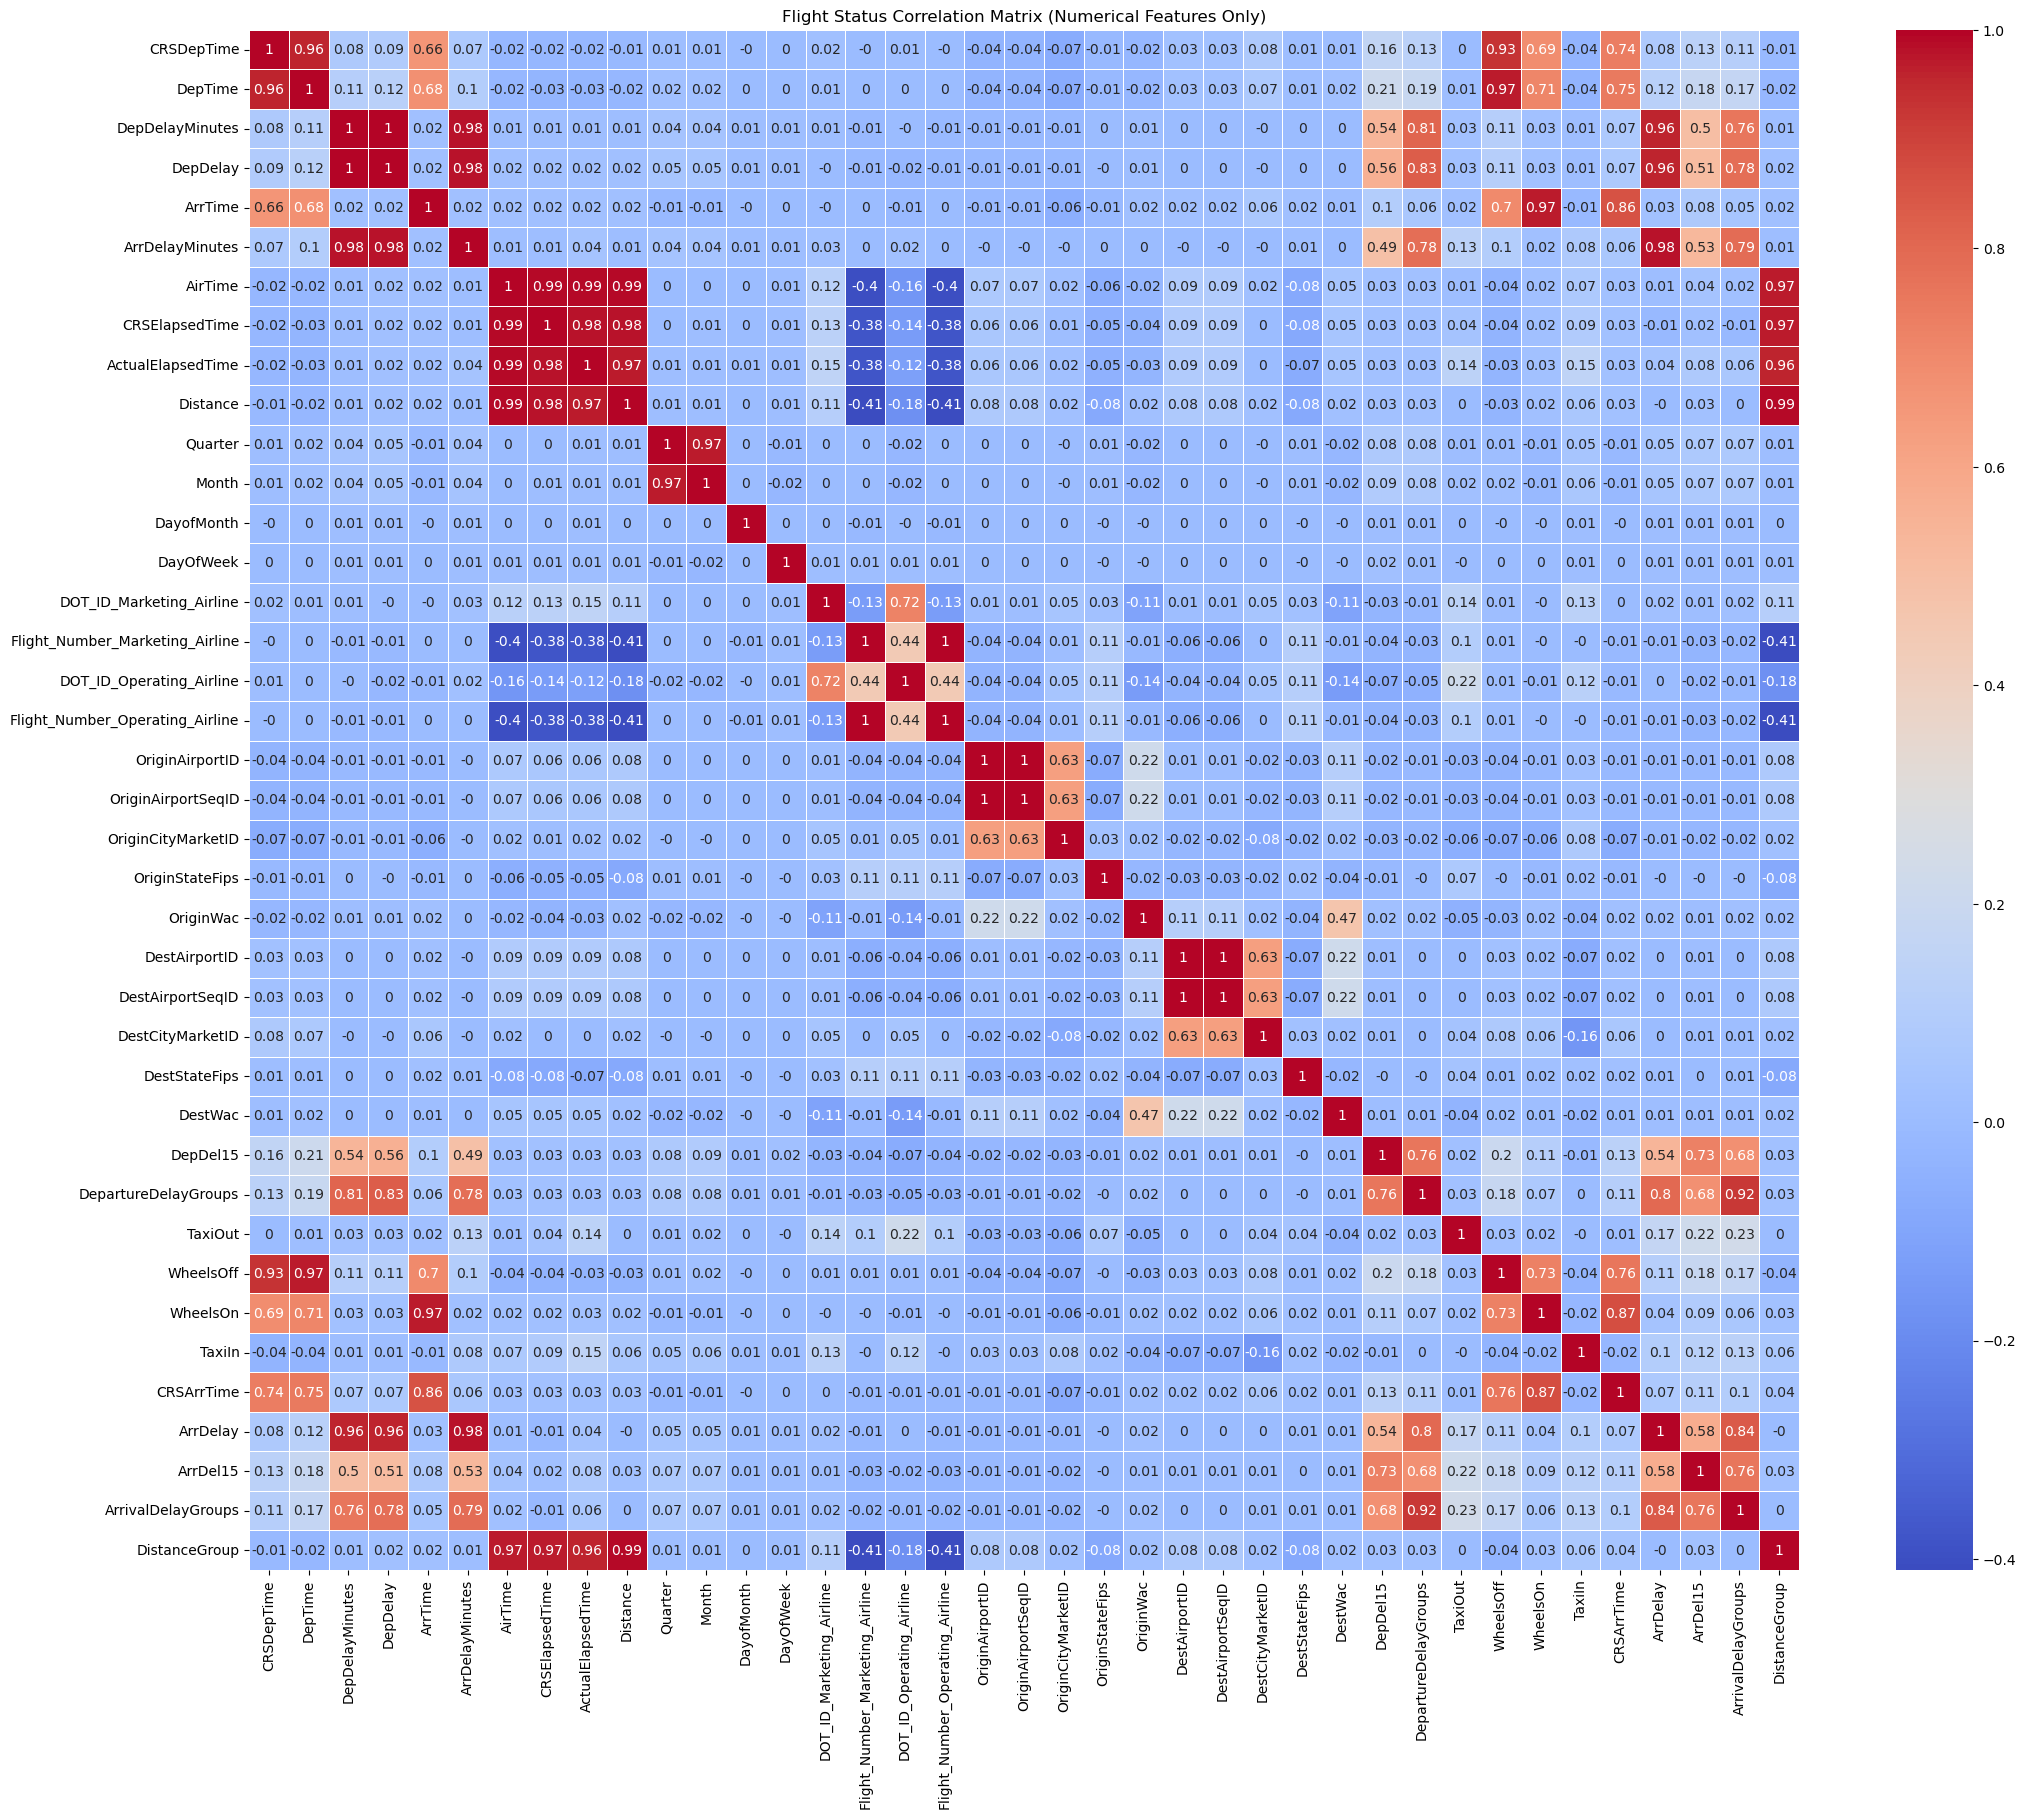

In [15]:
# display the corr matrix
fig, ax = plt.subplots(figsize=(25, 20))
sns.heatmap(round(corr_matrix, 2), annot=True, cmap='coolwarm', linewidths=0.5, ax=ax)
plt.title('Flight Status Correlation Matrix (Numerical Features Only)')
plt.show()

In [17]:
# creating the X (predictor) and y (target variable)
X = corr_df.drop('ArrDel15', axis=1)
y = corr_df['ArrDel15']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=99)   #creating training data set, 70% of the data




# Random Forest Classifier

Do not run the bottom chunk, takes over an hour

In [28]:
# create random forest classifier
rfc = RandomForestClassifier(random_state=1)

# grid search paramters
param_grid = {'n_estimators': range(0, 301, 100),
              'max_depth': range(5, 16, 5),
              'min_samples_split': range(2, 5, 1),
              'min_samples_leaf': range(1, 6, 2)}
              

# create grid search with cross validation of 5 folds
grid_search = GridSearchCV(rfc, param_grid, cv=2, scoring='accuracy', verbose=2, n_jobs=-1)

# perform grid search on training data
grid_search.fit(X_train, y_train)

# model with best parameters
best_rf_classifier = grid_search.best_estimator_

Fitting 2 folds for each of 108 candidates, totalling 216 fits
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=3, n_estimators=0; total time=   1.8s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=3, n_estimators=0; total time=   1.9s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=0; total time=   2.0s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=0; total time=   2.0s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=3, n_estimators=100; total time= 2.4min
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 2.4min
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 2.4min
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=3, n_estimators=100; total time= 2.4min
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=4, n_estimators=0; total time=   1.5s


/Users/geordy/opt/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=4, n_estimators=0; total time=   1.4s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time= 4.7min
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=3, n_estimators=200; total time= 4.6min
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time= 4.7min
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=3, n_estimators=200; total time= 4.7min
[CV] END max_depth=5, min_samples_leaf=3, min_samples_split=2, n_estimators=0; total time=   1.5s
[CV] END max_depth=5, min_samples_leaf=3, min_samples_split=2, n_estimators=0; total time=   1.5s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=4, n_estimators=100; total time= 2.3min
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=4, n_estimators=100; total time= 2.4min
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=3, n_estimators=300; total time= 6.8min
[CV] E

/Users/geordy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
54 fits failed out of a total of 216.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
54 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/geordy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/geordy/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 340, in fit
    self._validate_params()
  File "/Users/geordy/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py", line 581, in _validate_params
    validate_parameter_constrain

In [35]:
# Calculate accuracy, precision, recall, and F1 score 
y_test_pred_rcf = best_rf_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_test_pred_rcf)
precision = precision_score(y_test, y_test_pred_rcf)
recall = recall_score(y_test, y_test_pred_rcf)
f1 = f1_score(y_test, y_test_pred_rcf)

print("RFC Accuracy: ", accuracy)
print("RFC Precision: ", precision)
print("RFC Recall: ", recall)
print("RFC F1: ", f1)

RFC Accuracy:  1.0
RFC Precision:  1.0
RFC Recall:  1.0
RFC F1:  1.0


Super overfitting :(

In [29]:
#feature importance
feature_names = X.columns

feature_importances = best_rf_classifier.feature_importances_

sorted_indices = feature_importances.argsort()[::-1]

# Print the features in order of importance (most important first)
print("Feature Importance (descending order):")
for index in sorted_indices:
    print(f"{feature_names[index]}: {feature_importances[index]}")

Feature Importance (descending order):
ArrDelayMinutes: 0.255611944041622
ArrivalDelayGroups: 0.2411556190830284
ArrDelay: 0.1970868002350127
DepDelayMinutes: 0.1072459443346984
DepDelay: 0.0764590885282775
DepDel15: 0.07524869323544588
DepartureDelayGroups: 0.02567971977630162
TaxiOut: 0.009399251438690224
ArrTime: 0.0025249371519387004
WheelsOn: 0.0022279954841136923
TaxiIn: 0.0020604124495669706
DepTime: 0.0018578987543515346
WheelsOff: 0.0008110397727829751
CRSDepTime: 0.000669580950702532
CRSArrTime: 0.0006540143183199314
ActualElapsedTime: 0.0004663027484950391
CRSElapsedTime: 0.00027724108691672307
DOT_ID_Operating_Airline: 0.00023256257099196865
DOT_ID_Marketing_Airline: 0.000115960006260267
Quarter: 5.932521800294859e-05
Distance: 4.2327147048872756e-05
DistanceGroup: 3.4309889359225824e-05
AirTime: 2.755151476501929e-05
Month: 2.3826300550578025e-05
OriginWac: 1.1032663286296105e-05
Flight_Number_Operating_Airline: 1.1021160457728559e-05
Flight_Number_Marketing_Airline: 3.001

# QDA

In [32]:
# create qda
qda = QuadraticDiscriminantAnalysis()

# grid search paramters

param_grid = {'reg_param': np.linspace(0, 1, 11)}
              

# create grid search with cross validation of 5 folds
grid_search = GridSearchCV(qda, param_grid, cv=2, scoring='accuracy', verbose=2, n_jobs=-1)

# perform grid search on training data
grid_search.fit(X_train, y_train)

# model with best parameters
best_qda_classifier = grid_search.best_estimator_

Fitting 2 folds for each of 11 candidates, totalling 22 fits


/Users/geordy/opt/anaconda3/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/geordy/opt/anaconda3/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/geordy/opt/anaconda3/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/geordy/opt/anaconda3/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/geordy/opt/anaconda3/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/geordy/opt/anaconda3/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear

[CV] END ......................................reg_param=0.1; total time=  59.1s
[CV] END ......................................reg_param=0.4; total time=  59.4s
[CV] END ......................reg_param=0.30000000000000004; total time=  59.5s
[CV] END ......................................reg_param=0.2; total time=  59.5s
[CV] END ......................................reg_param=0.4; total time=  59.5s
[CV] END ......................................reg_param=0.0; total time=  59.5s
[CV] END ......................................reg_param=0.0; total time=  59.5s
[CV] END ......................................reg_param=0.2; total time=  59.6s
[CV] END ......................reg_param=0.30000000000000004; total time=  59.8s
[CV] END ......................................reg_param=0.5; total time=  59.8s
[CV] END ......................................reg_param=0.5; total time=  59.9s
[CV] END ......................................reg_param=0.1; total time= 1.0min


/Users/geordy/opt/anaconda3/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/geordy/opt/anaconda3/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/geordy/opt/anaconda3/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/geordy/opt/anaconda3/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/geordy/opt/anaconda3/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/geordy/opt/anaconda3/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear

[CV] END ......................................reg_param=0.8; total time=  45.8s
[CV] END .......................reg_param=0.6000000000000001; total time=  46.0s
[CV] END .......................reg_param=0.7000000000000001; total time=  46.0s
[CV] END ......................................reg_param=1.0; total time=  45.9s
[CV] END ......................................reg_param=0.9; total time=  46.2s
[CV] END .......................reg_param=0.7000000000000001; total time=  47.0s
[CV] END .......................reg_param=0.6000000000000001; total time=  47.2s
[CV] END ......................................reg_param=0.8; total time=  47.2s
[CV] END ......................................reg_param=0.9; total time=  47.3s
[CV] END ......................................reg_param=1.0; total time=  47.1s


/Users/geordy/opt/anaconda3/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


In [36]:
# Calculate accuracy, precision, recall, and F1 score 
y_test_pred_qda = best_qda_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_test_pred_qda)
precision = precision_score(y_test, y_test_pred_qda)
recall = recall_score(y_test, y_test_pred_qda)
f1 = f1_score(y_test, y_test_pred_qda)

print("RFC Accuracy: ", accuracy)
print("RFC Precision: ", precision)
print("RFC Recall: ", recall)
print("RFC F1: ", f1)

RFC Accuracy:  0.9802073111785408
RFC Precision:  0.9002205270193263
RFC Recall:  0.9956117641270503
RFC F1:  0.945516279256047


Still overfitting but not as bad as RFC

In [33]:
#feature importance
feature_names = X.columns

feature_importances = best_qda_classifier.feature_importances_

sorted_indices = feature_importances.argsort()[::-1]

# Print the features in order of importance (most important first)
print("Feature Importance (descending order):")
for index in sorted_indices:
    print(f"{feature_names[index]}: {feature_importances[index]}")

AttributeError: 'QuadraticDiscriminantAnalysis' object has no attribute 'feature_importances_'

Need to look up how to do feature importance for QDA

# Random Forest with Adaboost

In [8]:
#removing numeric features that are IDs
corr_df = corr_df.drop('OriginAirportID', axis=1)
corr_df = corr_df.drop('OriginAirportSeqID', axis=1)
corr_df = corr_df.drop('OriginCityMarketID', axis=1)
corr_df = corr_df.drop('DestAirportID', axis=1)
corr_df = corr_df.drop('DestAirportSeqID', axis=1)
corr_df = corr_df.drop('DestCityMarketID', axis=1)
corr_df = corr_df.drop('DOT_ID_Operating_Airline', axis=1)
corr_df = corr_df.drop('DOT_ID_Marketing_Airline', axis=1)
corr_df = corr_df.drop('OriginStateFips', axis=1)



X = corr_df.drop('ArrDel15', axis=1)
y = corr_df['ArrDel15']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=99)   #creating training data set, 70% of the data




In [11]:
# create random forest classifier with adaboost
rfc = RandomForestClassifier(random_state=1)
ada_rf_classifier = AdaBoostClassifier(base_estimator=rfc, random_state=1)

# grid search paramters using the same as random forest
param_grid = {'n_estimators': range(0, 301, 100),
              'max_depth': range(5, 16, 5),
              'min_samples_split': range(2, 5, 1),
              'min_samples_leaf': range(1, 6, 2)}
              

# create grid search with cross validation of 5 folds
grid_search = GridSearchCV(rfc, param_grid, cv=2, scoring='accuracy', verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

Fitting 2 folds for each of 108 candidates, totalling 216 fits


C:\Users\chels\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
54 fits failed out of a total of 216.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
54 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\chels\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\chels\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 392, in fit
    self._validate_estimator()
  File "C:\Users\chels\anaconda3\lib\site-packages\sklearn\ensemble\_base.py", line 138, in _validate_estimator
    raise ValueError(
ValueError: n_estimators must be greater than 

GridSearchCV(cv=2, estimator=RandomForestClassifier(random_state=1), n_jobs=-1,
             param_grid={'max_depth': range(5, 16, 5),
                         'min_samples_leaf': range(1, 6, 2),
                         'min_samples_split': range(2, 5),
                         'n_estimators': range(0, 301, 100)},
             scoring='accuracy', verbose=2)

In [12]:
# Calculate accuracy, precision, recall, and F1 score 
best_rfada_classifier = grid_search.best_estimator_
y_test_pred_rcfada = best_rfada_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_test_pred_rcfada)
precision = precision_score(y_test, y_test_pred_rcfada)
recall = recall_score(y_test, y_test_pred_rcfada)
f1 = f1_score(y_test, y_test_pred_rcfada)

print("RFC Accuracy: ", accuracy)
print("RFC Precision: ", precision)
print("RFC Recall: ", recall)
print("RFC F1: ", f1)

RFC Accuracy:  1.0
RFC Precision:  1.0
RFC Recall:  1.0
RFC F1:  1.0


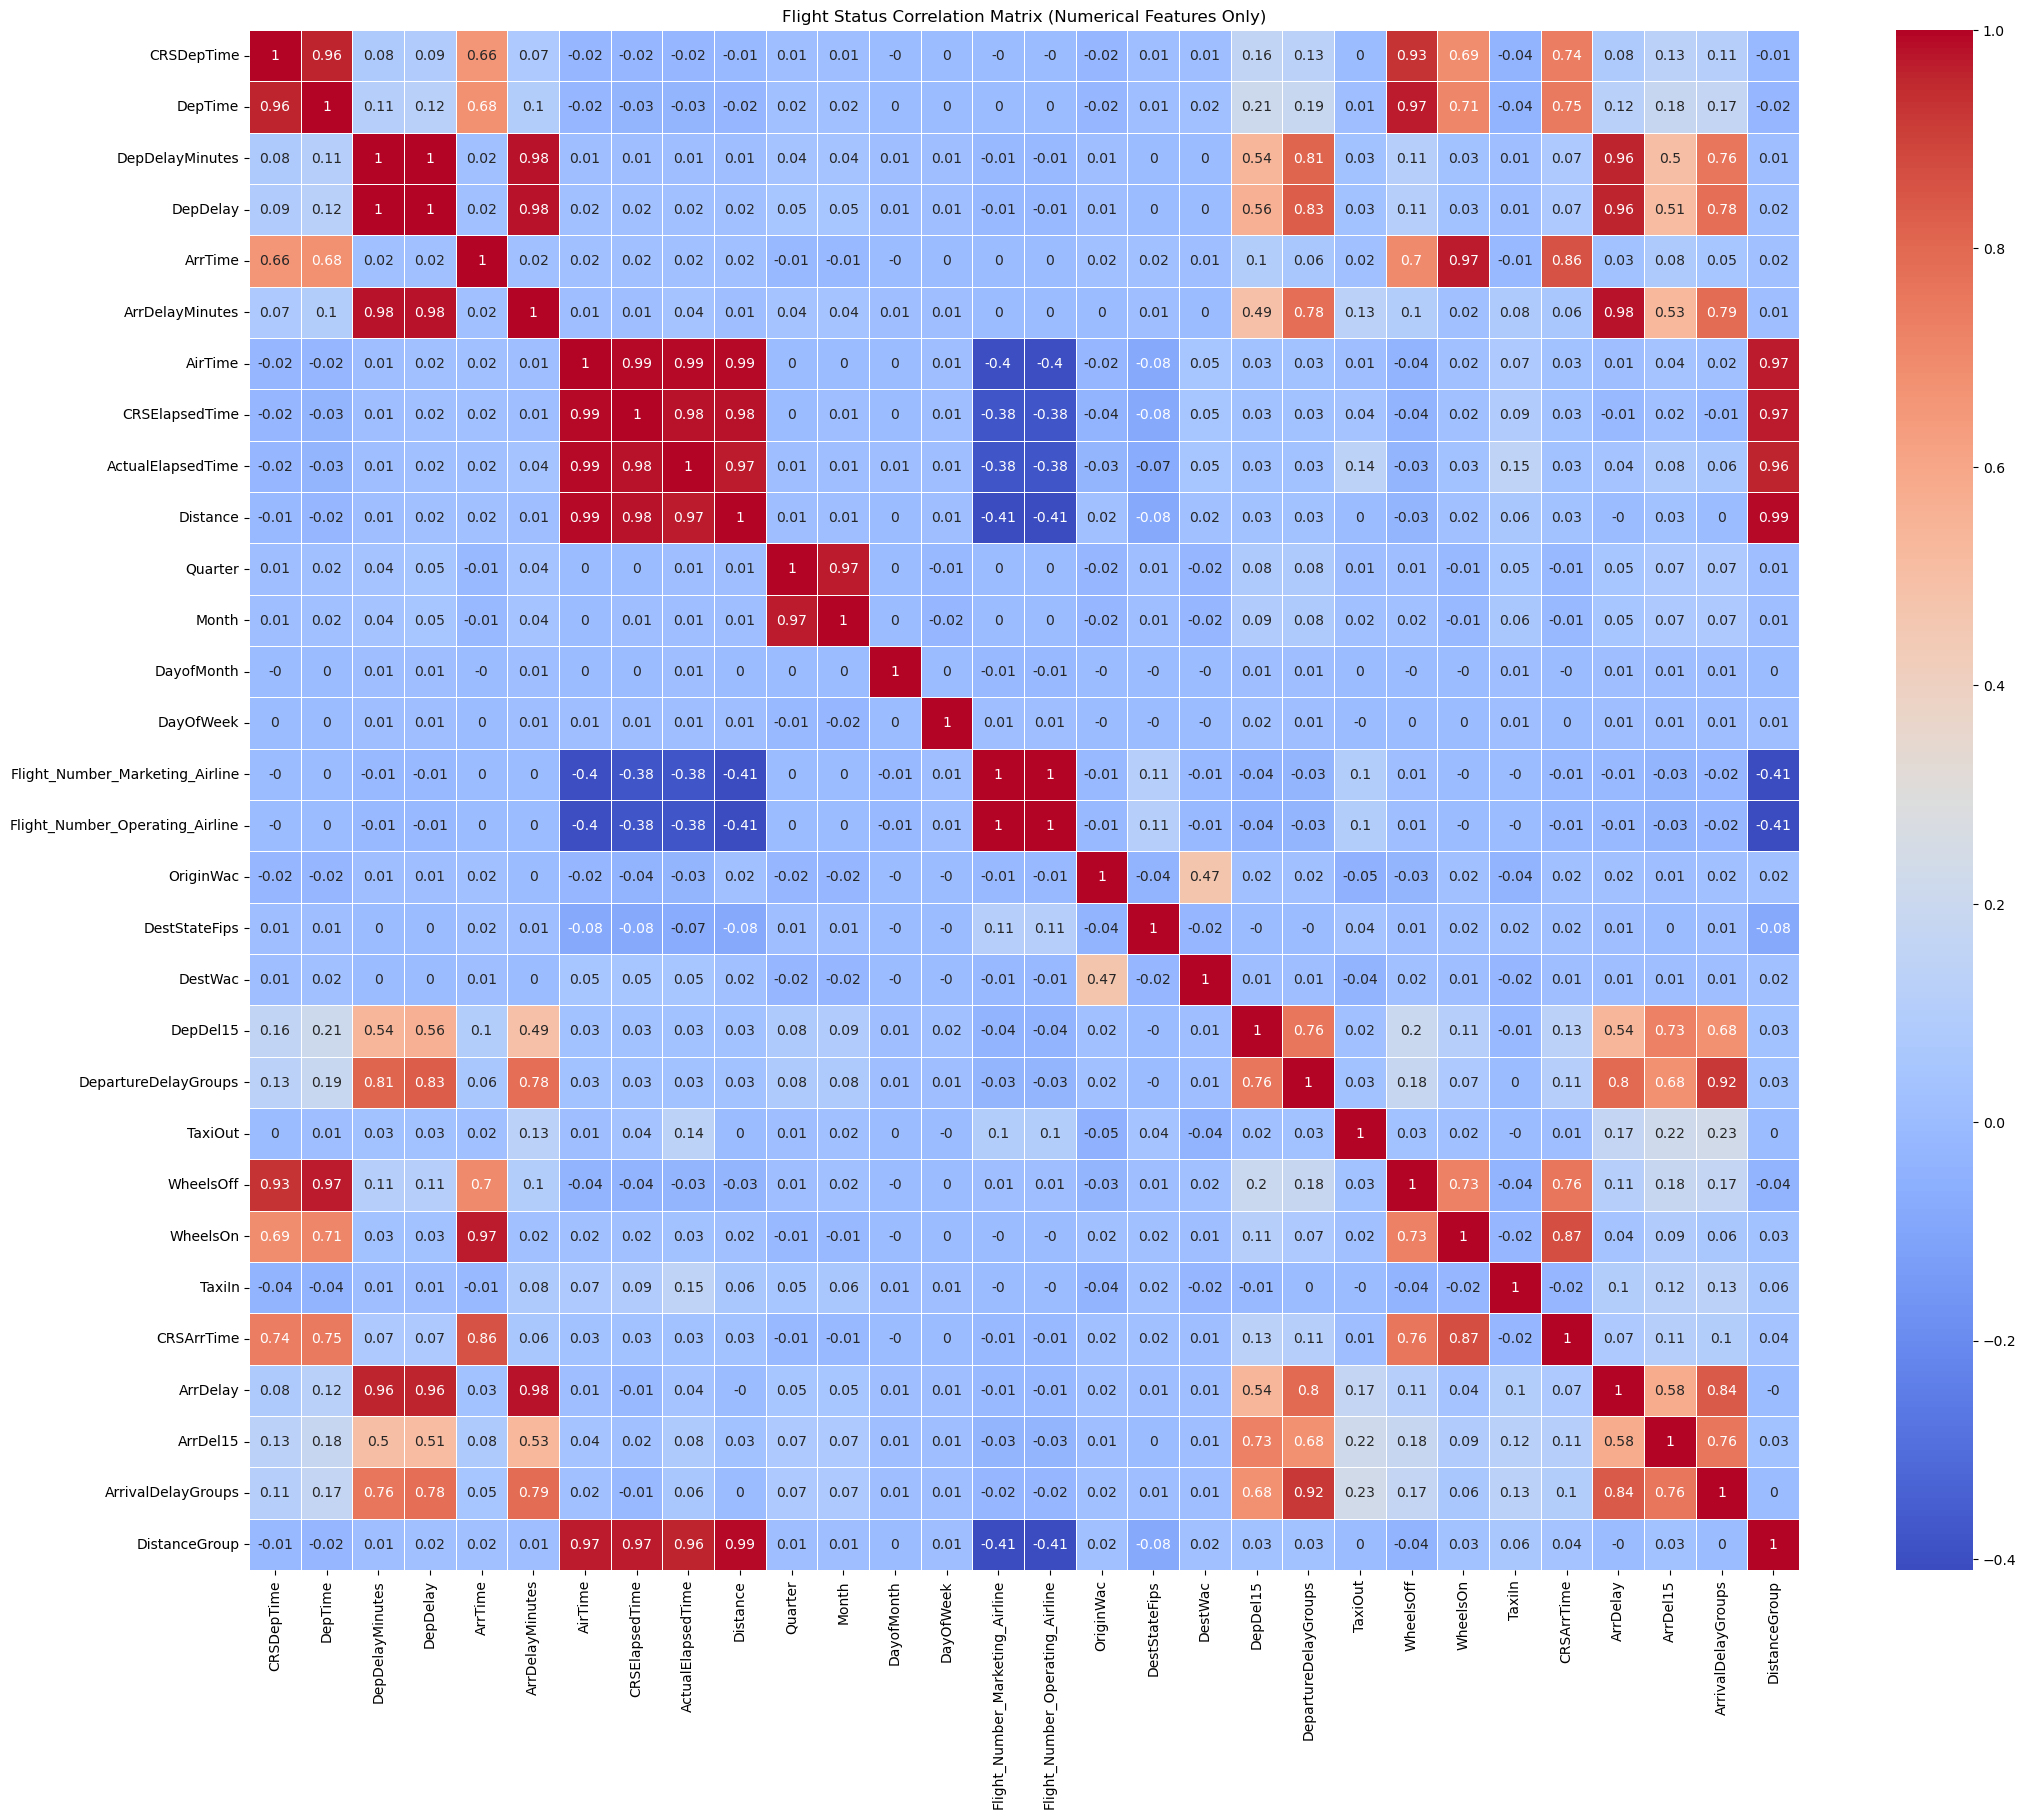

In [15]:
#Additional Data Analysis

#revising flight status correlation to remove ID values from maxtrix and saving image for report
corr_matrix = corr_df.corr()
fig, ax = plt.subplots(figsize=(25, 20))
sns.heatmap(round(corr_matrix, 2), annot=True, cmap='coolwarm', linewidths=0.5, ax=ax)
plt.title('Flight Status Correlation Matrix (Numerical Features Only)')
plt.savefig("corrMatrix.png")
plt.show()



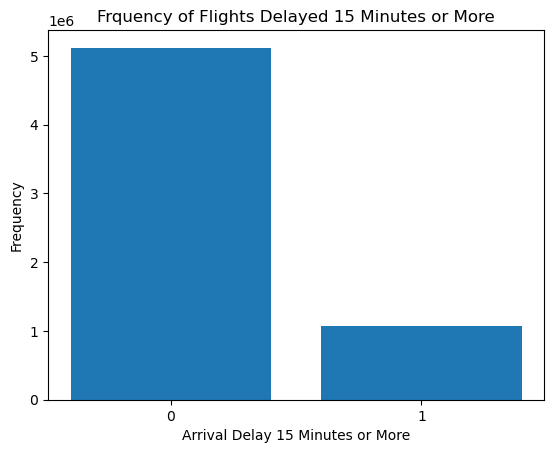

In [20]:
#generating bar chart with frequency of 
counts = df['ArrDel15'].value_counts()
plt.bar(counts.index, counts.values)
plt.xlabel('Arrival Delay 15 Minutes or More')
plt.ylabel('Frequency')
plt.title('Frquency of Flights Delayed 15 Minutes or More')
plt.xticks(counts.index) 
plt.savefig("FrequencyTargetVar.png")
plt.show()